In [1]:
import datetime as dt
import numpy as np
from facer import BaseModel, Model
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
from scipy.io import readsav

# Compare to plots using Coxon et al. (2016) data

To facilitate this comparison we subclass `Model` to create `IDLModel`, which ingests data from IDL sav files.

In [2]:
class IDLModel(Model):
    def __init__(self, hemisphere, ut, interval):
        self._n_labda = 40
        self._n_theta = 180
        self.labda = np.radians(np.linspace(0, 40, self._n_labda))
        self.theta = np.radians(np.linspace(0, 360, self._n_theta))
        self.colat = np.degrees(self.labda)
        self.mlt = np.degrees(self.theta) / 15
        
        save_file = readsav(f"sav/coxon_2016_{hemisphere}_interval={interval}.sav")
        
        if save_file["interval"] != interval:
            raise ValueError("Interval was mismatched.")        
        if save_file["hemisphere"].decode("utf-8") != hemisphere:
            raise ValueError("Hemisphere was mismatched.")

        if ut == 5:
            i = 0
        elif ut == 17:
            i = 1
        else:
            raise ValueError("UT must be 5 or 17.")
        
        self.hemisphere = hemisphere
        self.time = dt.datetime(2010, 1, 1) + dt.timedelta(days=int(save_file["doy"]))
        self.ut = save_file["ut"][i]
        self.phi_d = save_file["vd"] / 1e3
        self.phi_n = save_file["vn"] / 1e3
        self.f_107 = save_file["f_107"]
        self.f_pc = save_file["pc_flux"]
        self.r1_colat = save_file["pcb_colat"]
        self.delta_colat = save_file["delta_lat"]
        self.sza = np.radians(save_file["sza"][i,:,:].T)
        self.e_lambda = save_file["e_lambda"].T
        self.e_theta = save_file["e_theta"].T
        self.sigma_p = save_file["sigma_p_ut"][i,:,:].T
        self.sigma_h = save_file["sigma_h_ut"][i,:,:].T
        self.div_jp = save_file["div_jp_ut"][i,:,:].T
        self.div_jh = save_file["div_jh_ut"][i,:,:].T
        self.j = save_file["fac"][i]

Create two models at the same UT and same hemisphere, using specific values to benchmark against the IDL save data.

In [3]:
hemisphere = "north"
ut = 5

py_models = []
idl_models = []

for i in np.arange(82, dtype=int):
    idl_model = IDLModel(hemisphere, ut, i)

    py_models.append(Model(idl_model.phi_d, idl_model.phi_n, idl_model.f_107,
                           idl_model.time + dt.timedelta(hours=int(idl_model.ut)),
                           hemisphere, f_pc=idl_model.f_pc / 1e9, r1_colat=idl_model.r1_colat,
                           delta_colat=idl_model.delta_colat, precipitation_conductance="max"))
    
    idl_models.append(idl_model)

/opt/homebrew/Caskroom/mambaforge/base/envs/work/lib/python3.10/site-packages/birkeland/__init__.py:50: UserWarning: Setting both polar cap flux and R1 colatitude will set both manually. This is supported to allow comparisons with the original IDL, but is not recommended.
  warnings.warn("Setting both polar cap flux and R1 colatitude will set both manually. "


## Compare solar zenith angle _Z_

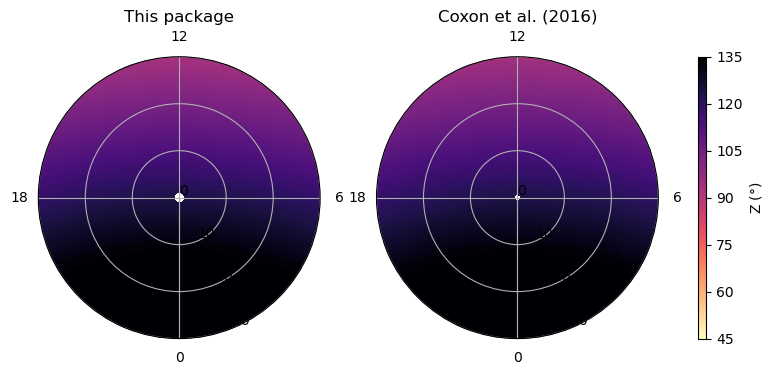

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), subplot_kw={"polar": True})
mesh = np.empty_like(ax, dtype=object)

ax[0].set_title("This package")
ax[1].set_title("Coxon et al. (2016)")

mesh[0] = py_models[-1].map_solar_zenith_angle(ax[0], contours=False)
mesh[1] = idl_models[-1].map_solar_zenith_angle(ax[1], contours=False)

cax = py_models[0].add_cax(fig, ax)
cbar = plt.colorbar(mesh[0], cax=cax)
cbar.ax.yaxis.set_major_locator(MaxNLocator(6))
cbar.set_label(r"Z ($\degree$)")

## Compare $\Sigma_H$ and $\Sigma_P$

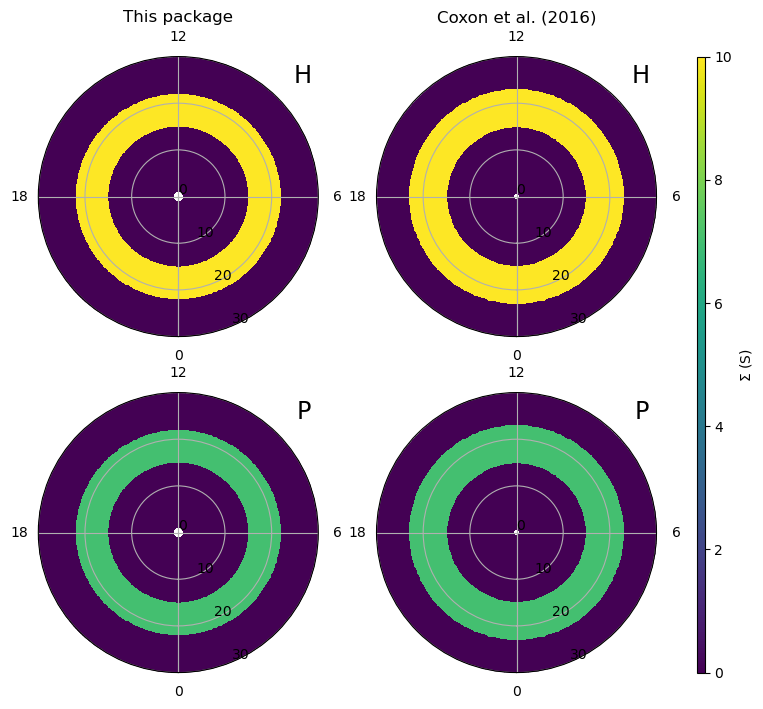

In [5]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8), subplot_kw={"polar": True})
mesh = np.empty_like(ax, dtype=object)

ax[0, 0].set_title("This package")
ax[0, 1].set_title("Coxon et al. (2016)")

components = ["hall", "pedersen"]

for row, _ in enumerate(ax):
    mesh[row, 0] = py_models[-1].map_sigma(ax[row, 0], components[row], contours=False)
    mesh[row, 1] = idl_models[-1].map_sigma(ax[row, 1], components[row], contours=False)
                                          
cax = py_models[0].add_cax(fig, ax)
cbar = plt.colorbar(mesh[0, 0], cax=cax)
cbar.ax.yaxis.set_major_locator(MaxNLocator(6))
cbar.set_label(r"$\Sigma$ (S)")

## Compare $\nabla.J_H$ and $\nabla.J_P$

This looks slightly different to the IDL code due to small changes in how the 

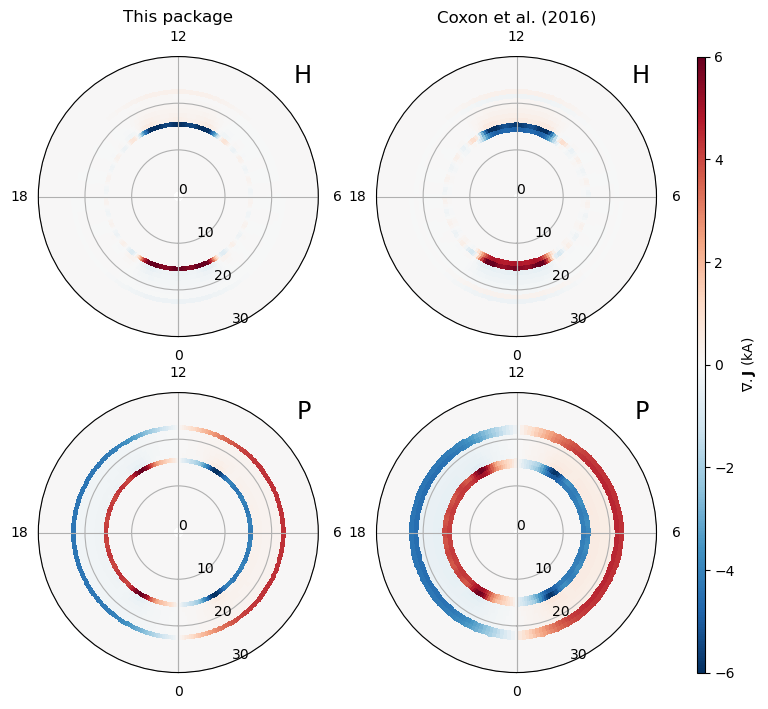

In [6]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8), subplot_kw={"polar": True})
mesh = np.empty_like(ax, dtype=object)

ax[0, 0].set_title("This package")
ax[0, 1].set_title("Coxon et al. (2016)")

components = ["hall", "pedersen"]

for row, _ in enumerate(ax):
    mesh[row, 0] = py_models[-1].map_div_j(ax[row, 0], components[row], contours=False)
    mesh[row, 1] = idl_models[-1].map_div_j(ax[row, 1], components[row], contours=False)

cax = py_models[0].add_cax(fig, ax)
cbar = plt.colorbar(mesh[0, 0], cax=cax)
cbar.ax.yaxis.set_major_locator(MaxNLocator(7))
cbar.set_label(r"$\nabla.\mathbf{J}$ (kA)")

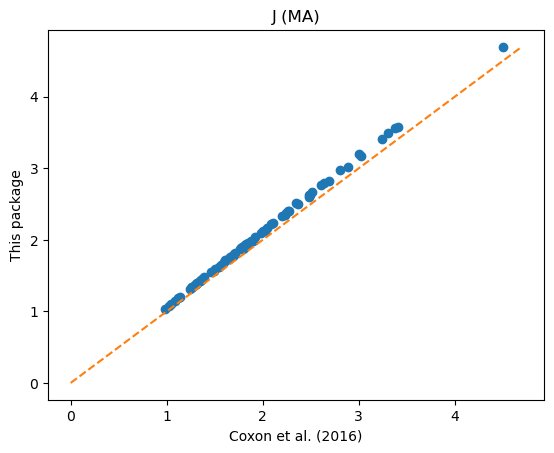

In [7]:
py_j = np.array([m.j for m in py_models])
idl_j = np.array([m.j for m in idl_models])

fig, ax = plt.subplots()
ax.plot([0, py_j.max() / 1e6], [0, py_j.max() / 1e6], ls="--", color="C1")
ax.scatter(idl_j / 1e6, py_j / 1e6)
ax.set(xlabel="Coxon et al. (2016)", ylabel="This package", title="J (MA)")

plt.show()